## Build a model to predict whether a customer will become inactive?

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

In [2]:
# Load files into a pandas dataframe
df = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
variables = pd.read_csv('VariableDescription.csv')

In [3]:
df.head()

,ID,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
0,ID_YEB05X4KUGPQ,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
1,ID_Z9IQ9QH52KVN,Nebula,K > 24 month,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,NaN,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,31.0,0
2,ID_YZSU7B7M35QS,Celestial,K > 24 month,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,NaN,1.0,NaN,NaN,NO,61,NaN,NaN,0
3,ID_QS4F5LEX29KM,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN,0
4,ID_8IYIC9PFU8U1,Eclipsara,K > 24 month,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,NaN,NaN,NO,62,Mixt 250F=Unlimited_call24H,31.0,0


In [4]:
 print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ID                1507834 non-null  object 
 1   region            913743 non-null   object 
 2   tenure            1507834 non-null  object 
 3   Amount            978320 non-null   float64
 4   refill_frequency  978320 non-null   float64
 5   revenue           999713 non-null   float64
 6   arpu_segment      999713 non-null   float64
 7   frequency         999713 non-null   float64
 8   data_volume       766028 non-null   float64
 9   on_net            957192 non-null   float64
 10  Procuct_1         881271 non-null   float64
 11  Procuct_2         604784 non-null   float64
 12  zone1             118986 non-null   float64
 13  zone2             95505 non-null    float64
 14  mrg               1507834 non-null  object 
 15  regularity        1507834 non-null  int64  
 16  

In [5]:
(df.isnull().sum()  / len(df) * 100).sort_values(ascending=False)

zone2               93.666080
zone1               92.108813
Procuct_2           59.890545
data_volume         49.196795
freq_top_pack       41.902690
top_pack            41.902690
Procuct_1           41.553845
region              39.400292
on_net              36.518741
Amount              35.117526
refill_frequency    35.117526
revenue             33.698736
arpu_segment        33.698736
frequency           33.698736
regularity           0.000000
ID                   0.000000
mrg                  0.000000
tenure               0.000000
Target               0.000000
dtype: float64

<AxesSubplot:>

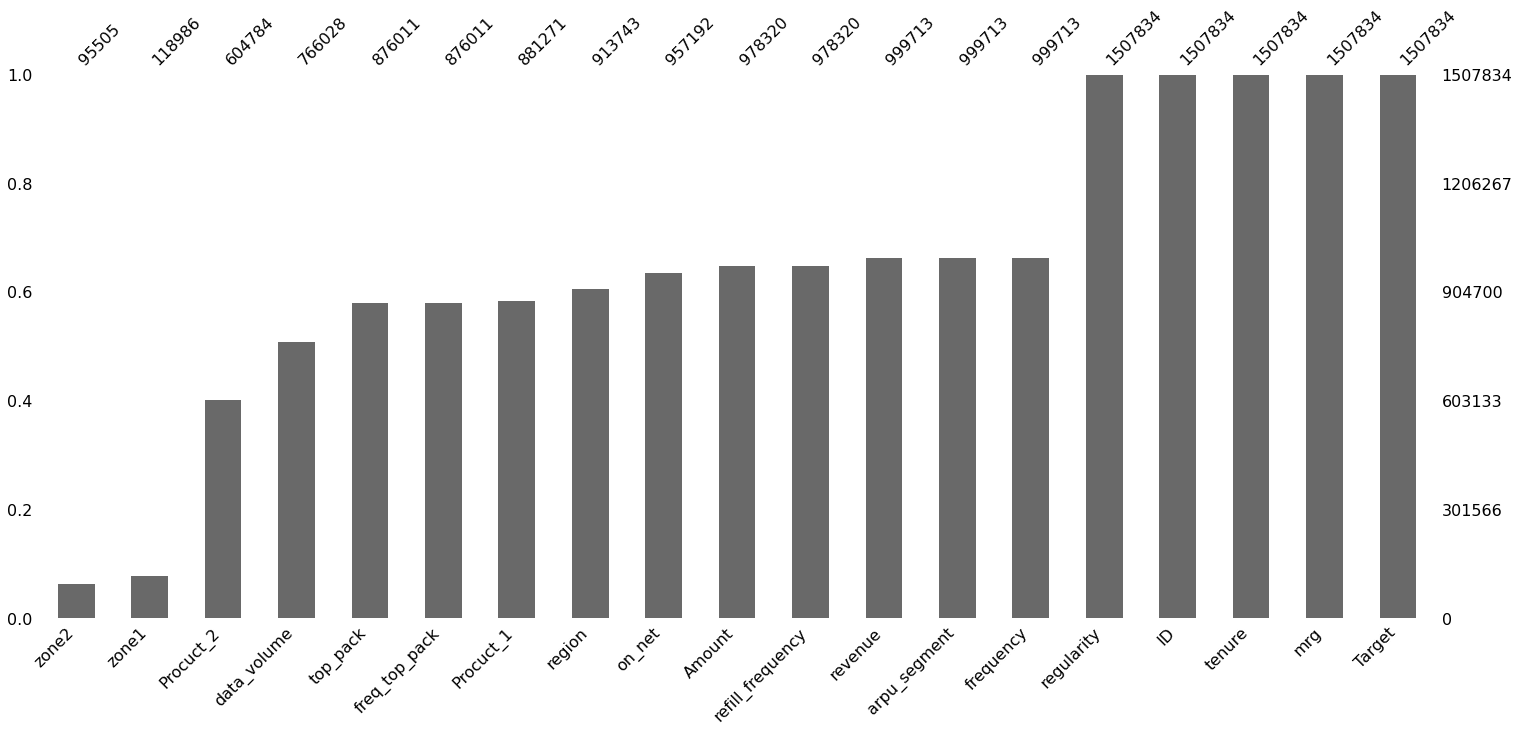

In [6]:
msno.bar(df, sort="ascending")

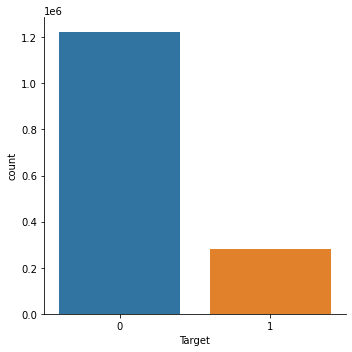

In [7]:
# Explore Target distribution 
sns.catplot(x="Target", kind="count", data=df)

In [8]:
#Separate training features from target
X_train = df.drop(['Target'], axis=1)
y_train = df['Target']

In [9]:
def preprocessing_data(data):
    # Create a DataFrame to preserve column names
    df = data.copy()

    # drop unwanted columns
    data = data.drop(['ID', 'top_pack', 'mrg'], axis=1)

    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=['region'])

    # Label Encoder conversion
    le = LabelEncoder()
    data["tenure"] = le.fit_transform(data["tenure"])

    # Drop columns with more than 49% missing values.
    high_missing_cols = df.columns[df.isnull().mean() > 0.49]
    data = data.drop(high_missing_cols, axis=1)
    
    # Impute missing values in object columns with mode
    object_cols = data.select_dtypes(include=['object']).columns
    data[object_cols] = data[object_cols].apply(lambda x: x.fillna(x.mode()[0]))

    # Impute missing values with the mean of each column
    data = data.apply(lambda col: col.fillna(col.mean()), axis=0)

    # Scale our data into the range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data[data.columns] = scaler.fit_transform(data[data.columns])

    # Convert the processed NumPy array back to a DataFrame
    processed_data = pd.DataFrame(data, columns=data.columns)

    return processed_data

In [10]:
cleaned_df = preprocessing_data(df)

In [11]:
processed_test = preprocessing_data(test)

## xgboost

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = cleaned_df.drop(['Target'], axis=1)
y = cleaned_df['Target']

# Create arrays for the features and the target: X, y
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic',
                          learning_rate=0.1,
                          max_depth=3,
                          n_estimators=100,
                          random_state=123
                         )
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("accuracy: %f" % (accuracy))

accuracy: 0.878578


In [12]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

X = cleaned_df.drop(['Target'], axis=1)
y = cleaned_df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [100],
    'class_weight': [{0: 1, 1: 2}, 'balanced'] 
}

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', random_state=123)

# Instantiate GridSearchCV
grid_search = GridSearchCV(xg_cl, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to make predictions
best_xg_cl = grid_search.best_estimator_
preds = best_xg_cl.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %f" % accuracy)

[20:10:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

Best Parameters: {'class_weight': {0: 1, 1: 2}, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.878578


### params for a large dataset

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

X = cleaned_df.drop(['Target'], axis=1)
y = cleaned_df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'class_weight': [{0: 1, 1: 2}, 'balanced'] 
}


# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', random_state=123)

# Instantiate GridSearchCV
grid_search = GridSearchCV(xg_cl, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parametersaa
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to make predictions
best_xg_cl = grid_search.best_estimator_
preds = best_xg_cl.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %f" % accuracy)

## LogisticRegression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform
from sklearn.metrics import accuracy_score

X = cleaned_df.drop(['Target'], axis=1)
y = cleaned_df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# create the models
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the data to the model
logreg.fit(X_train, y_train)
preds = logreg.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("accuracy: %f" % (accuracy))

accuracy: 0.833984


### LogisticRegression on a large dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform
from sklearn.metrics import accuracy_score

X = cleaned_df.drop(['Target'], axis=1)
y = cleaned_df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# create the models
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Create the parameter space
params = {
    'penalty': ['l1', 'l2'],
    'C': uniform(loc=0, scale=4),
    'solver': ['liblinear', 'saga']
}

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg, params, cv=kf, scoring='accuracy', n_iter=5, random_state=42)

# Fit the data to the model
logreg_cv.fit(X_train, y_train)

# Get the best parameters
best_params = logreg_cv.best_params_
print("Best Parameters:", best_params)

# Use the best model to make predictions
best_logreg = logreg_cv.best_estimator_
preds = best_logreg.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %f" % accuracy)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


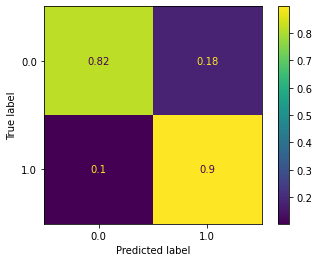

In [14]:
from sklearn.metrics import plot_confusion_matrix

# Get confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(logreg,X_test, y_test,normalize='true')

In [16]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89    245093
         1.0       0.53      0.90      0.67     56474

    accuracy                           0.83    301567
   macro avg       0.75      0.86      0.78    301567
weighted avg       0.89      0.83      0.85    301567



In [18]:
# Get the predicted result for the test Data
test.Target = logreg.predict(processed_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_12948\2102191889.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.Target = logreg.predict(processed_test)


In [19]:
ss.head()

,ID,Target
0,ID_LZ8K373W7EWV,0
1,ID_04KNWHGV5783,0
2,ID_CXS07G6VLB2U,0
3,ID_N3NFJJVHS25K,0
4,ID_R36J4ROT93E9,0


In [20]:
# Create submission DataFrame
submission = pd.DataFrame({"ID": test["ID"],
                           "Target": test.Target})

In [21]:
submission.head()

,ID,Target
0,ID_LZ8K373W7EWV,0.0
1,ID_04KNWHGV5783,0.0
2,ID_CXS07G6VLB2U,0.0
3,ID_N3NFJJVHS25K,0.0
4,ID_R36J4ROT93E9,1.0


In [23]:
submission.to_csv('submission2.csv', index=False)